In [79]:
import pandas as pd
import numpy as np
import yfinance as yf

In [80]:
#Cleaning the data set
data = pd.read_csv("spydata.csv")
data = data.drop(columns="Dividends")
del data["Stock Splits"]
data['Tomorrow'] = data["Close"].shift(-1)
data['Target'] = (data["Tomorrow"] > data["Close"]).astype(int)
data['Date'] = pd.to_datetime(data['Date'])
data = data[data['Date'] >= '1996-01-01']
data

,Date,Open,High,Low,Close,Volume,Tomorrow,Target
11571,1996-01-02,615.929993,620.739990,613.169983,620.729980,364180000,621.320007,1
11572,1996-01-03,620.729980,623.250000,619.559998,621.320007,468950000,617.700012,0
11573,1996-01-04,621.320007,624.489990,613.960022,617.700012,512580000,616.710022,0
11574,1996-01-05,617.700012,617.700012,612.020020,616.710022,437110000,618.460022,1
11575,1996-01-08,616.710022,618.460022,616.489990,618.460022,130360000,609.450012,0
...,...,...,...,...,...,...,...,...
18206,2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
18207,2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
18208,2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1
18209,2022-05-13,3963.899902,4038.879883,3963.899902,4023.889893,4142950000,4008.010010,0


<Axes: >

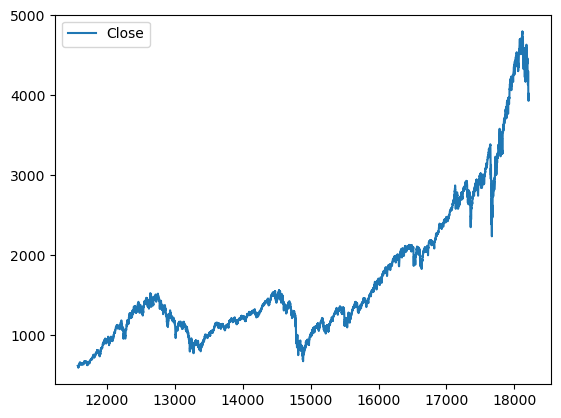

In [81]:
#Graph of sp500 data
data.plot(y="Close", use_index=True)

In [82]:
#base model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

model = RandomForestClassifier(n_estimators=500, min_samples_split=100, random_state=1)

x = ["Close", "Open", "High", "Low", "Volume"]
y = ['Target']

train_data = data.iloc[:-150]
test_data = data.iloc[-150:]

model.fit(train_data[x], train_data[y])


/opt/anaconda3/envs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=100, n_estimators=500, random_state=1)

In [56]:
#testing the model
predictions = model.predict(test_data[x])
predictions = pd.Series(predictions, test_data["Date"])

precision_score(test_data[y], predictions)

0.5

In [90]:
#backtesting system
def predict(train_data, test_data, x, model):
    model.fit(train_data[x], train_data["Target"])
    predictions = model.predict(test_data[x])
    predictions = pd.Series(predictions, index=test_data['Date'], name="Predictions")  # Add name for clarity
    combined = pd.concat([test_data["Target"], predictions], axis=1)
    return combined

In [91]:
def backtesting(stock_data, model, x, start=2500, step=250):
    all_predictions = []

    for i in range(start, stock_data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:i+step].copy()
        predictions = predict(train, test, x, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [92]:
predictions = backtesting(data, model, x)
predictions["Predictions"].value_counts()

Predictions
0.0    2307
1.0    1833
Name: count, dtype: int64

In [94]:
precision_score(predictions['Target'], predictions["Predictions"])

/opt/anaconda3/envs/machine_learning/lib/python3.9/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.